## Seleção de modelos


#### 1. Análise exploratória dos dados. 

Verificar qual os tipos de dados de entrada, se são homo ou heterogêneos. Existe alguma relação entre os dados? A saída segue alguma distribuição de probabilidade diferente da normal (p/ regressão)? Os dados são desbalanceados (p/ classificação). 

#### 2. Começar simples, e depois construir complexidade.

Sempre começo pelo modelo linear: LinearRegression (p/ regressão) ou LogisticRegression (p/ classificação). Testo outros modelos usando a função cross_val_score e cross_val_predict.

#### 3. Selecionar um grupo de modelos competitivos e diversos entre si.

Escolho uns 3-5 modelos que sejam o mais diferente possível entre si (normalmente linear, algum comitê de árvores, rede neural ou KNN). É importante que você descarte aqueles modelos que estejam muito complexo para o seu problema, ou que não estão convergindo.

#### 4. Ajustar de modelos usando um esquema de validação + algoritmo de busca.

Usando o conjunto de treino, busca-se ajustar a complexidade dos modelos utilizando um conjunto de parâmetros e um procedimento de busca (normalmente a busca exaustiva, usando a função GridSearchCV)

#### 5. Experimentar novos atributos

O ajuste de modelos é trabalho do computador, enquanto nosso trabalho é alimentar os modelos. Para isso, revisita-se os dados de entrada, tenta-se obter insights para gerar novos atributos que tenham lógica e que ajudem o modelo. Para isso podem ser utilizadas as saídas de importância dos modelos já ajustados, que vão direcionar nosso trabalho.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Regressão

In [2]:
df = pd.read_csv('../Dados/wine-reviews.csv')
df.head()

X, y = df.drop(['points','description'],axis=1), df['points']

A seguir foi realizado o preprocessamento das variáveis por via de pipeline, imputando valores faltantes, normalizando variaveis numéricas e condificando variáveis categóricas.

É interessante caso queira entender o processo de automação do preprocessamento, mas entraremos em maior detalhes no próximo capítulo.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['price']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_new = preprocessor.fit_transform(X)

In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#est = LinearRegression()
#est = SVR(kernel='linear')
#est = KNeighborsRegressor()
#est = Ridge()
est = DecisionTreeRegressor()
scores = cross_val_score(est, X_new, y, cv=5)

In [5]:
scores.mean()

0.5305632726992857

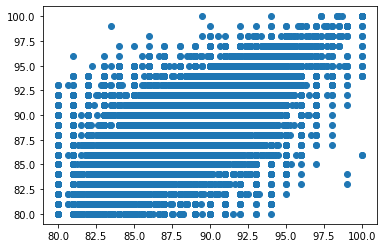

In [6]:
y_pred = cross_val_predict(est, X_new, y, cv=5)
plt.scatter(y_pred, y)
plt.show()

## Classificação

Lendo um banco de dados com informações de amostra de sementes de trigo: http://archive.ics.uci.edu/ml/datasets/seeds
Problema de classificação com 3 classes.

In [30]:
df = pd.read_csv('../Dados/seeds.csv')
df.head()

,area,perimiter,compactness,length,width,asymmetry,groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [52]:
df['class'].value_counts()

3    70
2    70
1    70
Name: class, dtype: int64

Classes estão balanceadas.

In [90]:
from sklearn.model_selection import train_test_split

X, y = df.drop(['class'],axis=1), df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=36, random_state=42)

Divisão em treino e teste (33 amostras = ~15% dos dados). Como usamos o parametro stratify, os conjuntos treino e teste possuem a mesma proporção de dados:

In [91]:
y_test.value_counts()

3    12
2    12
1    12
Name: class, dtype: int64

Calculando a acurácia da árvore de decisão, com os parâmetros default:

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X_train, y_train, cv=5)
print(tree_scores.round(3))
print(tree_scores.mean().round(3))

[0.889 0.889 0.833 0.97  0.939]
0.904


Note que são usados 5 folds, logo temos 5 valores pra acurácia. Usaremos a média.

Calculando a acurácia da Regressão Logística:

In [123]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', multi_class='auto')
logit_scores = cross_val_score(logit, X_train, y_train, cv=5)
print(logit_scores.mean().round(3))

0.919


## Ajuste de modelos



In [121]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1,50),
          'criterion':['gini','entropy'],
}

gs = GridSearchCV(tree, param_grid=params, cv=5)

gs.fit(X_train,y_train)

print("Melhores parâmetros: ")
gs.best_params_

Melhores parâmetros: 


C:\Users\rsantis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'entropy', 'max_depth': 2}

In [120]:
print("Acurácia da melhor árvore de decisão no conjunto de treino: {0:.3f}".format(gs.best_score_))

Acurácia da melhor árvore de decisão no conjunto de treino: 0.920


In [119]:
from sklearn.metrics import accuracy_score
y_pred = gs.predict(X_test)

print("Acurácia da melhor árvore de decisão no conjunto de teste: {0:.3f}".format(accuracy_score(y_test,y_pred)))

Acurácia da melhor árvore de decisão no conjunto de teste: 0.972


In [124]:
logit.fit(X_train, y_train)

print("Acurácia da regressão logística: {0:.3f}".format(accuracy_score(y_test,logit.predict(X_test))))

Acurácia da regressão logística: 0.917


Parece que o jogo mudou, não é mesmo?

## Matriz de Correlação

Uma forma muito utilizada de avaliação é a matriz de confusão.

Existe uma função no sklearn que mostra a matriz de confusão no console. A função abaixo mostra a matriz de confusão como uma imagem.

Normalized confusion matrix
[[0.91666667 0.         0.08333333]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]


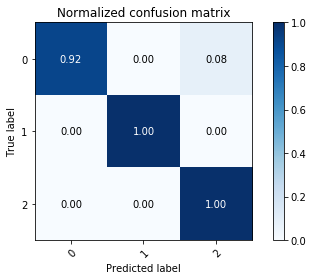

In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, y_pred, classes=['0','1','2'], normalize=True,
                      title='Normalized confusion matrix')

## Esquemas de Validação

Ver a documentação: [Scikit-learn Crossvalidation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)